# Pytorch CNN Image Classification

In [ ]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 17.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 10.9 MB/s eta 0:00:00


In [ ]:
pip install torchvision

In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR
import torch.optim as optim
from torchmetrics import Accuracy
import optuna
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Calculate mean and std of the train data

In [ ]:
def get_mean_std(dataloader):

    # Initialize the sums and the number of batches
    sum = 0.0
    sum_squared = 0.0
    num_batches = 0

    # Loop through the data in the DataLoader
    for data, _ in tqdm(dataloader, desc="Computing mean and std"):
        sum += data.mean()
        sum_squared += (data ** 2).mean()
        num_batches += 1

    # Divide by the total number of batches to get the mean
    mean = sum / num_batches

    # Calculate the std deviation
    std = (sum_squared / num_batches - mean ** 2) ** 0.5

    print(f'Mean: {mean}')
    print(f'Std: {std}')


    return mean, std

## Set correct device for hardware acceleratiion

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class ToDeviceLoader:
    def __init__(self,data,device):
        self.data = data
        self.device = device

    def __iter__(self):
        for batch in self.data:
            yield to_device(batch,self.device)

    def __len__(self):
        return len(self.data)

In [ ]:
# apply the transformations and calculate the mean and std
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load your dataset
dataset = datasets.ImageFolder(root= 'drive/MyDrive/train', transform=transform)

device = get_device()
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

dataset = ToDeviceLoader(dataloader, device)

mean, std = get_mean_std(dataset)

## Set labels accordingly by overwrite the ImageFolder function

In [ ]:
class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None):
        super().__init__(root, transform=transform, target_transform=target_transform)

    def find_classes(self, dir):
        """
        Override this method to load from setting file instead of scanning directory
        """
        labels = {
            'bedroom': 1,
            'Coast': 2,
            'Forest': 3,
            'Highway': 4,
            'industrial': 5,
            'Insidecity': 6,
            'kitchen': 7,
            'livingroom': 8,
            'Mountain': 9,
            'Office': 10,
            'OpenCountry': 11,
            'store': 12,
            'Street': 13,
            'Suburb': 14,
            'TallBuilding': 15
        }

        classes = list(labels.keys())
        classes_to_idx = labels
        return classes, classes_to_idx

# referenced from https://discuss.pytorch.org/t/what-is-the-simplest-way-to-change-class-to-idx-attribute/86778/4

## Overwrite Dataset function to apply data augmentation on training data after random split

In [ ]:
class TrDataset(Dataset):
    def __init__(self, base_dataset, transformations):
        super(TrDataset, self).__init__()
        self.base = base_dataset
        self.transformations = transformations

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        x, y = self.base[idx]
        return self.transformations(x), y

# referenced from https://stackoverflow.com/questions/74920920/pytorch-apply-data-augmentation-on-training-data-after-random-split

## load data, apply train validataion split and respective transformations(augmentation)

In [ ]:
def load_data(mean, std, path, batch_size):
    # Transformations for the training data with augmentation
    train_transform = transforms.Compose([
    # # Data augmentation
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 1.0)),
    transforms.RandomPerspective(distortion_scale=0.6, p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.Resize((256, 256)),       # Resize images to 256x256
    transforms.Grayscale(num_output_channels=1),  # Ensure there is only one channel
    transforms.ToTensor(),               # Convert images to PyTorch tensors
    # Normalize the images
    transforms.Normalize(mean= [mean], std= [std]),  # Use the mean and std dev for grayscale images
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.4), ratio=(0.3, 3.3), value=0)
    ])

    # Transformations for the validation data without augmentation
    validation_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean], std=[std])
    ])

    full_dataset = CustomImageFolder(root=path)
    print(full_dataset.class_to_idx)
    # Split dataset into training and validation sets
    train_size = int(0.8 * len(full_dataset))
    validation_size = len(full_dataset) - train_size
    raw_train_dataset, raw_validation_dataset = random_split(full_dataset, [train_size, validation_size])

    # Create custom datasets with the respective transformations
    train_dataset = TrDataset(raw_train_dataset, train_transform)
    validation_dataset = TrDataset(raw_validation_dataset, validation_transform)

    # Data loaders for training and validation sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, validation_loader

## Define ResNet framework

In [ ]:
# referenced from https://www.kaggle.com/code/toygarr/resnet-implementation-for-image-classification

def conv_shortcut(in_channel, out_channel, stride):
    layers = [nn.Conv2d(in_channel, out_channel, kernel_size=(1,1), stride=(stride, stride)),
             nn.BatchNorm2d(out_channel)]
    return nn.Sequential(*layers)

def block(in_channel, out_channel, k_size,stride):
    layers = None

    first_layers = [nn.Conv2d(in_channel,out_channel[0], kernel_size=(1,1),stride=(stride,stride)),
                    nn.BatchNorm2d(out_channel[0]),
                    nn.ReLU()
                    ]

    second_layers = [nn.Conv2d(out_channel[0], out_channel[1], kernel_size=(k_size, k_size), stride=(1,1), padding=1),
                    nn.BatchNorm2d(out_channel[1]),
                    nn.ReLU()
                    ]

    layers = first_layers + second_layers

    return nn.Sequential(*layers)


class ResNet(nn.Module):

    def __init__(self, in_channels, num_classes, stage2_loop, stage3_loop, dropout1, dropout2, out_channels):
        super().__init__()

        self.stage2_loop = stage2_loop
        self.stage3_loop = stage3_loop
        self.dropout1 = dropout1
        self.dropout2 = dropout2
        self.out_channels = out_channels

        self.stg1 = nn.Sequential(
                                   nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3),
                                             stride=(1), padding=1),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))

        ##stage 2
        self.convShortcut2 = conv_shortcut(out_channels,out_channels*2,1)

        self.conv2 = block(out_channels,[out_channels//2,out_channels*2],3,1)
        self.ident2 = block(out_channels*2,[out_channels,out_channels*2],3,1)


        # ##stage 3
        self.convShortcut3 = conv_shortcut(out_channels*2,out_channels*4,2)

        self.conv3 = block(out_channels*2,[out_channels,out_channels*4],3,2)
        self.ident3 = block(out_channels*4,[out_channels*2,out_channels*4],3,1)

        ##Classify
        self.classifier = nn.Sequential(
                                       nn.AvgPool2d(2),
                                       nn.Dropout(self.dropout1),
                                       nn.Flatten(),
                                       nn.Dropout(self.dropout2),
                                       nn.LazyLinear(num_classes))

    def forward(self,inputs):
        #stage 1
        out = self.stg1(inputs)

        #stage 2
        out = F.relu(self.conv2(out) + self.convShortcut2(out))
        for _ in range(self.stage2_loop):
            out = F.relu(self.ident2(out) + out)

        # Stage 3
        out = F.relu(self.conv3(out) + self.convShortcut3(out))
        for _ in range(self.stage3_loop):
            out = F.relu(self.ident3(out) + out)

        #Classify
        out = self.classifier(out)

        return out


## Define early stopping machenism

In [ ]:
# referenced from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopping:
    def __init__(self, patience=7):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.min_validation_loss:
            self.min_validation_loss = val_loss
            self.counter = 0
        elif val_loss > self.min_validation_loss:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

## Define the training process of the model

In [ ]:
global_best_accuracy = 0

def train_model(model, train_loader, val_loader, optimizer, n_epochs, early_stopping, criterion, grad_clip=None, scheduler=None, accuracy=None):
    torch.cuda.empty_cache()

    history = []
    local_best_accuracy = 0

    for epoch in range(n_epochs):

        result = {}
        train_loss = []
        validation_loss = []


        model.train()
        for data, target in tqdm(train_loader, desc=f'Epoch {epoch+1} Training'):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target - 1) # Subtract 1 from the target since the labels start from 1
            train_loss.append(loss)
            loss.backward()
            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            scheduler.step()

        result['train_loss'] = torch.stack(train_loss).mean().item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in tqdm(val_loader, desc=f'Epoch {epoch+1} Validation'):
                output = model(data)
                val_loss = criterion(output, target - 1).detach()
                validation_loss.append(val_loss)
                preds = torch.argmax(output, dim=1)  # Get the predicted class labels
                accuracy(preds , target-1)  # Update the running accuracy

        val_acc = accuracy.compute()
        accuracy.reset()
        result['val_loss'] = torch.stack(validation_loss).mean().item()


        current_lr = optimizer.param_groups[0]['lr']

        result['lrs'] = current_lr
        result['val_acc'] = val_acc

        history.append(result)

        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, current_lr, result['train_loss'], result['val_loss'], result['val_acc']))

        if val_acc > local_best_accuracy:
            local_best_accuracy = val_acc

        global global_best_accuracy

        if val_acc > global_best_accuracy:
          global_best_accuracy = val_acc
          torch.save(model, 'best-model-parameters.pt')
          print(f'Saved new best model with accuracy: {val_acc}%')

        # Call early stopping
        early_stopping(result['val_loss'])
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return history, local_best_accuracy

## Define a optuna objective function for hyperparameter tuning, using bayesian optimization

In [ ]:
global_history = []

# def objective(trial):

n_epochs = 300
num_classes = 15
patience = 50
channels = 1
path = 'drive/MyDrive/train'
# batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
# lr = trial.suggest_float('lr', 1e-4, 1e-1,log = True)
# weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-1,log = True)
# grad_clip = trial.suggest_float('grad_clip', 0.1, 5.0)
# state1_loop = trial.suggest_int('state1_loop', 0, 5)
# state2_loop = trial.suggest_int('state2_loop', 0, 5)
# dropout1 = trial.suggest_float('dropout1', 0, 0.5)
# dropout2 = trial.suggest_float('dropout2', 0, 0.5)
# out_channels = trial.suggest_categorical('out_channels', [8, 16, 32, 64, 128])
#optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

# below are the best hyperparameters found by optuna, additional epochs were run to ensure a best model
batch_size = 16
lr = 0.004304870060658268
weight_decay = 0.0007918823690228014
grad_clip = 1.572382720992464
state1_loop = 0
state2_loop = 0
dropout1 = 0.212104912726848
dropout2 = 0.33715478476437205
out_channels = 64
optimizer_name = 'SGD'

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)

model = ResNet(channels, num_classes, state1_loop, state2_loop, dropout1, dropout2, out_channels)

optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr,weight_decay = weight_decay)

train_loader, validation_loader = load_data(0.45624029636383057, 0.25140705704689026,path,batch_size)

# move model and dataset to GPU/CPU
device = get_device()
train_loader = ToDeviceLoader(train_loader, device)
valid_loader = ToDeviceLoader(validation_loader, device)
resnet_model = to_device(model, device)

criterion = nn.CrossEntropyLoss()
accuracy = Accuracy(task="multiclass", num_classes=15).to(device)
early_stopping = EarlyStopping(patience=patience)
scheduler = OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=n_epochs)
history, best_accuracy = train_model(resnet_model, train_loader, valid_loader, optimizer, n_epochs, early_stopping, criterion, grad_clip, scheduler, accuracy)

global_history.append(history)

# return best_accuracy

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


{'bedroom': 1, 'Coast': 2, 'Forest': 3, 'Highway': 4, 'industrial': 5, 'Insidecity': 6, 'kitchen': 7, 'livingroom': 8, 'Mountain': 9, 'Office': 10, 'OpenCountry': 11, 'store': 12, 'Street': 13, 'Suburb': 14, 'TallBuilding': 15}


Epoch 1 Validation: 100%|██████████| 19/19 [03:57<00:00, 12.48s/it]


Epoch [1], last_lr: 0.00017, train_loss: 12.0808, val_loss: 11.6689, val_acc: 0.2167
Saved new best model with accuracy: 0.21666666865348816%


Epoch 2 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.88it/s]


Epoch [2], last_lr: 0.00018, train_loss: 11.0717, val_loss: 9.0622, val_acc: 0.2800
Saved new best model with accuracy: 0.2800000011920929%


Epoch 3 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.88it/s]


Epoch [3], last_lr: 0.00018, train_loss: 10.3421, val_loss: 8.3323, val_acc: 0.3167
Saved new best model with accuracy: 0.3166666626930237%


Epoch 4 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.86it/s]


Epoch [4], last_lr: 0.00019, train_loss: 8.5119, val_loss: 6.7294, val_acc: 0.2967


Epoch 5 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.51it/s]


Epoch [5], last_lr: 0.00020, train_loss: 6.3234, val_loss: 5.7532, val_acc: 0.3200
Saved new best model with accuracy: 0.3199999928474426%


Epoch 6 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.07it/s]


Epoch [6], last_lr: 0.00022, train_loss: 5.1718, val_loss: 3.9939, val_acc: 0.4233
Saved new best model with accuracy: 0.4233333468437195%


Epoch 7 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.84it/s]


Epoch [7], last_lr: 0.00023, train_loss: 4.1194, val_loss: 3.5263, val_acc: 0.3567


Epoch 8 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.86it/s]


Epoch [8], last_lr: 0.00025, train_loss: 3.2168, val_loss: 3.2158, val_acc: 0.3267


Epoch 9 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.73it/s]


Epoch [9], last_lr: 0.00027, train_loss: 2.7802, val_loss: 2.4320, val_acc: 0.4500
Saved new best model with accuracy: 0.44999998807907104%


Epoch 10 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.02it/s]


Epoch [10], last_lr: 0.00030, train_loss: 2.6858, val_loss: 2.8445, val_acc: 0.3667


Epoch 11 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.65it/s]


Epoch [11], last_lr: 0.00032, train_loss: 2.5228, val_loss: 2.8759, val_acc: 0.4133


Epoch 12 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.61it/s]


Epoch [12], last_lr: 0.00035, train_loss: 2.7069, val_loss: 2.1151, val_acc: 0.4633
Saved new best model with accuracy: 0.4633333384990692%


Epoch 13 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.83it/s]


Epoch [13], last_lr: 0.00038, train_loss: 2.2850, val_loss: 2.0275, val_acc: 0.4500


Epoch 14 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.01it/s]


Epoch [14], last_lr: 0.00041, train_loss: 2.1800, val_loss: 1.8319, val_acc: 0.4667
Saved new best model with accuracy: 0.46666666865348816%


Epoch 15 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.41it/s]


Epoch [15], last_lr: 0.00045, train_loss: 2.0259, val_loss: 1.8222, val_acc: 0.4533


Epoch 16 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.85it/s]


Epoch [16], last_lr: 0.00049, train_loss: 1.8619, val_loss: 2.0729, val_acc: 0.4567


Epoch 17 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.02it/s]


Epoch [17], last_lr: 0.00053, train_loss: 1.7313, val_loss: 1.7444, val_acc: 0.4900
Saved new best model with accuracy: 0.49000000953674316%


Epoch 18 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.78it/s]


Epoch [18], last_lr: 0.00057, train_loss: 1.7070, val_loss: 1.6956, val_acc: 0.4600


Epoch 19 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.93it/s]


Epoch [19], last_lr: 0.00061, train_loss: 1.7331, val_loss: 1.7278, val_acc: 0.5133
Saved new best model with accuracy: 0.5133333206176758%


Epoch 20 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.27it/s]


Epoch [20], last_lr: 0.00066, train_loss: 1.7019, val_loss: 1.6083, val_acc: 0.5033


Epoch 21 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.54it/s]


Epoch [21], last_lr: 0.00070, train_loss: 1.6600, val_loss: 1.4948, val_acc: 0.4933


Epoch 22 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.15it/s]


Epoch [22], last_lr: 0.00075, train_loss: 1.6110, val_loss: 1.5400, val_acc: 0.5267
Saved new best model with accuracy: 0.5266666412353516%


Epoch 23 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.70it/s]


Epoch [23], last_lr: 0.00080, train_loss: 1.5719, val_loss: 1.5728, val_acc: 0.5400
Saved new best model with accuracy: 0.5400000214576721%


Epoch 24 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.79it/s]


Epoch [24], last_lr: 0.00086, train_loss: 1.5710, val_loss: 1.4031, val_acc: 0.5567
Saved new best model with accuracy: 0.5566666722297668%


Epoch 25 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.63it/s]


Epoch [25], last_lr: 0.00091, train_loss: 1.6242, val_loss: 1.3401, val_acc: 0.5767
Saved new best model with accuracy: 0.5766666531562805%


Epoch 26 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.85it/s]


Epoch [26], last_lr: 0.00097, train_loss: 1.5573, val_loss: 1.3937, val_acc: 0.5833
Saved new best model with accuracy: 0.5833333134651184%


Epoch 27 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.01it/s]


Epoch [27], last_lr: 0.00102, train_loss: 1.4705, val_loss: 1.4856, val_acc: 0.5567


Epoch 28 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.99it/s]


Epoch [28], last_lr: 0.00108, train_loss: 1.4935, val_loss: 1.5516, val_acc: 0.5200


Epoch 29 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.83it/s]


Epoch [29], last_lr: 0.00114, train_loss: 1.5044, val_loss: 1.3102, val_acc: 0.5633


Epoch 30 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.18it/s]


Epoch [30], last_lr: 0.00121, train_loss: 1.4879, val_loss: 1.5049, val_acc: 0.5467


Epoch 31 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.93it/s]


Epoch [31], last_lr: 0.00127, train_loss: 1.5193, val_loss: 1.6492, val_acc: 0.5200


Epoch 32 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.07it/s]


Epoch [32], last_lr: 0.00133, train_loss: 1.4225, val_loss: 1.4523, val_acc: 0.5300


Epoch 33 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.34it/s]


Epoch [33], last_lr: 0.00140, train_loss: 1.4225, val_loss: 1.3507, val_acc: 0.6000
Saved new best model with accuracy: 0.6000000238418579%


Epoch 34 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.87it/s]


Epoch [34], last_lr: 0.00146, train_loss: 1.4035, val_loss: 1.3457, val_acc: 0.5667


Epoch 35 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.20it/s]


Epoch [35], last_lr: 0.00153, train_loss: 1.3930, val_loss: 1.3570, val_acc: 0.5567


Epoch 36 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.89it/s]


Epoch [36], last_lr: 0.00160, train_loss: 1.3500, val_loss: 1.4185, val_acc: 0.5733


Epoch 37 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.88it/s]


Epoch [37], last_lr: 0.00167, train_loss: 1.3750, val_loss: 1.4638, val_acc: 0.5267


Epoch 38 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.17it/s]


Epoch [38], last_lr: 0.00174, train_loss: 1.3316, val_loss: 1.3887, val_acc: 0.5867


Epoch 39 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.07it/s]


Epoch [39], last_lr: 0.00181, train_loss: 1.3348, val_loss: 1.1504, val_acc: 0.6433
Saved new best model with accuracy: 0.6433333158493042%


Epoch 40 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.53it/s]


Epoch [40], last_lr: 0.00188, train_loss: 1.4396, val_loss: 1.3649, val_acc: 0.5967


Epoch 41 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.10it/s]


Epoch [41], last_lr: 0.00195, train_loss: 1.3119, val_loss: 1.5284, val_acc: 0.5433


Epoch 42 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.62it/s]


Epoch [42], last_lr: 0.00202, train_loss: 1.3431, val_loss: 1.3925, val_acc: 0.6133


Epoch 43 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.99it/s]


Epoch [43], last_lr: 0.00209, train_loss: 1.3091, val_loss: 1.4888, val_acc: 0.5433


Epoch 44 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.00it/s]


Epoch [44], last_lr: 0.00217, train_loss: 1.3011, val_loss: 1.4252, val_acc: 0.5767


Epoch 45 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.57it/s]


Epoch [45], last_lr: 0.00224, train_loss: 1.3017, val_loss: 1.4472, val_acc: 0.5600


Epoch 46 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.77it/s]


Epoch [46], last_lr: 0.00231, train_loss: 1.2721, val_loss: 1.3884, val_acc: 0.5633


Epoch 47 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.94it/s]


Epoch [47], last_lr: 0.00238, train_loss: 1.3209, val_loss: 1.5459, val_acc: 0.5567


Epoch 48 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.79it/s]


Epoch [48], last_lr: 0.00246, train_loss: 1.2793, val_loss: 1.2879, val_acc: 0.5967


Epoch 49 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.09it/s]


Epoch [49], last_lr: 0.00253, train_loss: 1.2392, val_loss: 1.2112, val_acc: 0.6400


Epoch 50 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.00it/s]


Epoch [50], last_lr: 0.00260, train_loss: 1.2736, val_loss: 1.3830, val_acc: 0.5900


Epoch 51 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.63it/s]


Epoch [51], last_lr: 0.00267, train_loss: 1.2315, val_loss: 1.3646, val_acc: 0.5900


Epoch 52 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.91it/s]


Epoch [52], last_lr: 0.00274, train_loss: 1.2896, val_loss: 1.2822, val_acc: 0.5933


Epoch 53 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.73it/s]


Epoch [53], last_lr: 0.00281, train_loss: 1.2338, val_loss: 1.2545, val_acc: 0.6133


Epoch 54 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.72it/s]


Epoch [54], last_lr: 0.00288, train_loss: 1.2180, val_loss: 1.3361, val_acc: 0.5933


Epoch 55 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.99it/s]


Epoch [55], last_lr: 0.00295, train_loss: 1.1449, val_loss: 1.4579, val_acc: 0.5867


Epoch 56 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.51it/s]


Epoch [56], last_lr: 0.00301, train_loss: 1.2290, val_loss: 1.1892, val_acc: 0.6333


Epoch 57 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.77it/s]


Epoch [57], last_lr: 0.00308, train_loss: 1.2099, val_loss: 1.1618, val_acc: 0.6200


Epoch 58 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.88it/s]


Epoch [58], last_lr: 0.00314, train_loss: 1.1994, val_loss: 1.1396, val_acc: 0.6467
Saved new best model with accuracy: 0.6466666460037231%


Epoch 59 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.87it/s]


Epoch [59], last_lr: 0.00321, train_loss: 1.1134, val_loss: 1.3251, val_acc: 0.6133


Epoch 60 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.83it/s]


Epoch [60], last_lr: 0.00327, train_loss: 1.1505, val_loss: 1.1438, val_acc: 0.6233


Epoch 61 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.49it/s]


Epoch [61], last_lr: 0.00333, train_loss: 1.1826, val_loss: 1.2103, val_acc: 0.6033


Epoch 62 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.96it/s]


Epoch [62], last_lr: 0.00339, train_loss: 1.1280, val_loss: 1.3993, val_acc: 0.6133


Epoch 63 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.39it/s]


Epoch [63], last_lr: 0.00345, train_loss: 1.1115, val_loss: 1.3482, val_acc: 0.5967


Epoch 64 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.52it/s]


Epoch [64], last_lr: 0.00351, train_loss: 1.1333, val_loss: 1.3057, val_acc: 0.6300


Epoch 65 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.10it/s]


Epoch [65], last_lr: 0.00357, train_loss: 1.1074, val_loss: 1.4152, val_acc: 0.5833


Epoch 66 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.72it/s]


Epoch [66], last_lr: 0.00362, train_loss: 1.1093, val_loss: 1.1002, val_acc: 0.6433


Epoch 67 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.88it/s]


Epoch [67], last_lr: 0.00367, train_loss: 1.1492, val_loss: 1.2914, val_acc: 0.5867


Epoch 68 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.92it/s]


Epoch [68], last_lr: 0.00373, train_loss: 1.0780, val_loss: 1.3327, val_acc: 0.6233


Epoch 69 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.96it/s]


Epoch [69], last_lr: 0.00377, train_loss: 1.1108, val_loss: 1.2156, val_acc: 0.6100


Epoch 70 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.86it/s]


Epoch [70], last_lr: 0.00382, train_loss: 1.0509, val_loss: 1.4468, val_acc: 0.5733


Epoch 71 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.51it/s]


Epoch [71], last_lr: 0.00387, train_loss: 1.0836, val_loss: 1.5288, val_acc: 0.5567


Epoch 72 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.09it/s]


Epoch [72], last_lr: 0.00391, train_loss: 1.0282, val_loss: 1.1042, val_acc: 0.6800
Saved new best model with accuracy: 0.6800000071525574%


Epoch 73 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.21it/s]


Epoch [73], last_lr: 0.00395, train_loss: 1.0520, val_loss: 1.4121, val_acc: 0.5800


Epoch 74 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.86it/s]


Epoch [74], last_lr: 0.00399, train_loss: 1.0836, val_loss: 1.2915, val_acc: 0.6567


Epoch 75 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.89it/s]


Epoch [75], last_lr: 0.00403, train_loss: 1.0633, val_loss: 1.0717, val_acc: 0.6767


Epoch 76 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.60it/s]


Epoch [76], last_lr: 0.00406, train_loss: 0.9904, val_loss: 1.1894, val_acc: 0.6133


Epoch 77 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.65it/s]


Epoch [77], last_lr: 0.00410, train_loss: 0.9915, val_loss: 1.1743, val_acc: 0.6433


Epoch 78 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.50it/s]


Epoch [78], last_lr: 0.00413, train_loss: 1.0505, val_loss: 1.4986, val_acc: 0.5800


Epoch 79 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.02it/s]


Epoch [79], last_lr: 0.00415, train_loss: 0.9870, val_loss: 1.1514, val_acc: 0.6600


Epoch 80 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.75it/s]


Epoch [80], last_lr: 0.00418, train_loss: 0.9638, val_loss: 1.1385, val_acc: 0.6867
Saved new best model with accuracy: 0.6866666674613953%


Epoch 81 Validation: 100%|██████████| 19/19 [00:01<00:00,  9.96it/s]


Epoch [81], last_lr: 0.00420, train_loss: 1.0205, val_loss: 1.0395, val_acc: 0.6833


Epoch 82 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.59it/s]


Epoch [82], last_lr: 0.00423, train_loss: 0.9543, val_loss: 1.0942, val_acc: 0.7000
Saved new best model with accuracy: 0.699999988079071%


Epoch 83 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.11it/s]


Epoch [83], last_lr: 0.00424, train_loss: 0.9262, val_loss: 1.1826, val_acc: 0.6700


Epoch 84 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.90it/s]


Epoch [84], last_lr: 0.00426, train_loss: 0.9919, val_loss: 1.2344, val_acc: 0.6300


Epoch 85 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.94it/s]


Epoch [85], last_lr: 0.00427, train_loss: 0.9821, val_loss: 1.2487, val_acc: 0.6233


Epoch 86 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.97it/s]


Epoch [86], last_lr: 0.00428, train_loss: 0.9905, val_loss: 1.2562, val_acc: 0.6367


Epoch 87 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.31it/s]


Epoch [87], last_lr: 0.00429, train_loss: 0.9897, val_loss: 1.0721, val_acc: 0.6867


Epoch 88 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.83it/s]


Epoch [88], last_lr: 0.00430, train_loss: 0.9427, val_loss: 1.0726, val_acc: 0.6767


Epoch 89 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.14it/s]


Epoch [89], last_lr: 0.00430, train_loss: 0.8834, val_loss: 1.1759, val_acc: 0.6567


Epoch 90 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.89it/s]


Epoch [90], last_lr: 0.00430, train_loss: 0.8878, val_loss: 1.4628, val_acc: 0.6367


Epoch 91 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.07it/s]


Epoch [91], last_lr: 0.00430, train_loss: 0.8900, val_loss: 1.0575, val_acc: 0.6833


Epoch 92 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.07it/s]


Epoch [92], last_lr: 0.00430, train_loss: 0.9674, val_loss: 1.1807, val_acc: 0.6467


Epoch 93 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.50it/s]


Epoch [93], last_lr: 0.00430, train_loss: 0.9420, val_loss: 1.2212, val_acc: 0.6700


Epoch 94 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.79it/s]


Epoch [94], last_lr: 0.00430, train_loss: 0.9342, val_loss: 1.2910, val_acc: 0.6433


Epoch 95 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.91it/s]


Epoch [95], last_lr: 0.00430, train_loss: 0.9228, val_loss: 1.1999, val_acc: 0.6700


Epoch 96 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.19it/s]


Epoch [96], last_lr: 0.00430, train_loss: 0.9013, val_loss: 1.2263, val_acc: 0.6367


Epoch 97 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.92it/s]


Epoch [97], last_lr: 0.00429, train_loss: 0.9532, val_loss: 1.1949, val_acc: 0.6733


Epoch 98 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.56it/s]


Epoch [98], last_lr: 0.00429, train_loss: 0.8689, val_loss: 1.1041, val_acc: 0.6567


Epoch 99 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.96it/s]


Epoch [99], last_lr: 0.00429, train_loss: 0.8918, val_loss: 1.4393, val_acc: 0.6100


Epoch 100 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.75it/s]


Epoch [100], last_lr: 0.00428, train_loss: 0.8941, val_loss: 1.3500, val_acc: 0.6267


Epoch 101 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.92it/s]


Epoch [101], last_lr: 0.00428, train_loss: 0.8285, val_loss: 1.2145, val_acc: 0.6400


Epoch 102 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.03it/s]


Epoch [102], last_lr: 0.00427, train_loss: 0.8375, val_loss: 1.2944, val_acc: 0.6667


Epoch 103 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.24it/s]


Epoch [103], last_lr: 0.00426, train_loss: 0.8940, val_loss: 1.1309, val_acc: 0.6700


Epoch 104 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.06it/s]


Epoch [104], last_lr: 0.00426, train_loss: 0.9182, val_loss: 1.0572, val_acc: 0.6933


Epoch 105 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.02it/s]


Epoch [105], last_lr: 0.00425, train_loss: 0.8391, val_loss: 1.1094, val_acc: 0.6633


Epoch 106 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.66it/s]


Epoch [106], last_lr: 0.00424, train_loss: 0.8767, val_loss: 1.3032, val_acc: 0.6567


Epoch 107 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.11it/s]


Epoch [107], last_lr: 0.00424, train_loss: 0.8670, val_loss: 1.2714, val_acc: 0.6967


Epoch 108 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.70it/s]


Epoch [108], last_lr: 0.00423, train_loss: 0.8545, val_loss: 1.2452, val_acc: 0.6500


Epoch 109 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.03it/s]


Epoch [109], last_lr: 0.00422, train_loss: 0.8418, val_loss: 1.1215, val_acc: 0.6867


Epoch 110 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.02it/s]


Epoch [110], last_lr: 0.00421, train_loss: 0.7871, val_loss: 1.1316, val_acc: 0.6833


Epoch 111 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.98it/s]


Epoch [111], last_lr: 0.00420, train_loss: 0.8585, val_loss: 1.1235, val_acc: 0.6667


Epoch 112 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.98it/s]


Epoch [112], last_lr: 0.00419, train_loss: 0.7816, val_loss: 1.3095, val_acc: 0.6733


Epoch 113 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.33it/s]


Epoch [113], last_lr: 0.00418, train_loss: 0.8383, val_loss: 1.2433, val_acc: 0.6667


Epoch 114 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.06it/s]


Epoch [114], last_lr: 0.00417, train_loss: 0.7758, val_loss: 1.1697, val_acc: 0.6967


Epoch 115 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.61it/s]


Epoch [115], last_lr: 0.00416, train_loss: 0.8049, val_loss: 1.3081, val_acc: 0.6400


Epoch 116 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.99it/s]


Epoch [116], last_lr: 0.00414, train_loss: 0.8205, val_loss: 1.2450, val_acc: 0.6733


Epoch 117 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.65it/s]


Epoch [117], last_lr: 0.00413, train_loss: 0.7917, val_loss: 1.3077, val_acc: 0.6400


Epoch 118 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.43it/s]


Epoch [118], last_lr: 0.00412, train_loss: 0.8260, val_loss: 1.1587, val_acc: 0.6633


Epoch 119 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.93it/s]


Epoch [119], last_lr: 0.00411, train_loss: 0.8124, val_loss: 1.2035, val_acc: 0.6567


Epoch 120 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.89it/s]


Epoch [120], last_lr: 0.00409, train_loss: 0.8078, val_loss: 1.3027, val_acc: 0.6367


Epoch 121 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.79it/s]


Epoch [121], last_lr: 0.00408, train_loss: 0.7141, val_loss: 1.0702, val_acc: 0.6700


Epoch 122 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.98it/s]


Epoch [122], last_lr: 0.00406, train_loss: 0.7942, val_loss: 1.0788, val_acc: 0.6733


Epoch 123 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.27it/s]


Epoch [123], last_lr: 0.00405, train_loss: 0.7596, val_loss: 1.2175, val_acc: 0.6767


Epoch 124 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.80it/s]


Epoch [124], last_lr: 0.00403, train_loss: 0.7771, val_loss: 1.1019, val_acc: 0.6767


Epoch 125 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.98it/s]


Epoch [125], last_lr: 0.00402, train_loss: 0.7872, val_loss: 1.2073, val_acc: 0.6867


Epoch 126 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.11it/s]


Epoch [126], last_lr: 0.00400, train_loss: 0.7183, val_loss: 1.2283, val_acc: 0.6600


Epoch 127 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.53it/s]


Epoch [127], last_lr: 0.00398, train_loss: 0.7557, val_loss: 1.0630, val_acc: 0.7367
Saved new best model with accuracy: 0.7366666793823242%


Epoch 128 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.67it/s]


Epoch [128], last_lr: 0.00397, train_loss: 0.7594, val_loss: 1.0722, val_acc: 0.6867


Epoch 129 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.07it/s]


Epoch [129], last_lr: 0.00395, train_loss: 0.7834, val_loss: 1.2841, val_acc: 0.6633


Epoch 130 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.01it/s]


Epoch [130], last_lr: 0.00393, train_loss: 0.7536, val_loss: 1.1735, val_acc: 0.6733


Epoch 131 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.94it/s]


Epoch [131], last_lr: 0.00391, train_loss: 0.7686, val_loss: 1.0918, val_acc: 0.7000


Epoch 132 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.02it/s]


Epoch [132], last_lr: 0.00389, train_loss: 0.7452, val_loss: 1.1794, val_acc: 0.6867


Epoch 133 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.64it/s]


Epoch [133], last_lr: 0.00387, train_loss: 0.7279, val_loss: 1.2077, val_acc: 0.6833


Epoch 134 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.83it/s]


Epoch [134], last_lr: 0.00385, train_loss: 0.6991, val_loss: 1.3367, val_acc: 0.6867


Epoch 135 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.01it/s]


Epoch [135], last_lr: 0.00384, train_loss: 0.7943, val_loss: 1.6203, val_acc: 0.6100


Epoch 136 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.23it/s]


Epoch [136], last_lr: 0.00381, train_loss: 0.7155, val_loss: 1.1616, val_acc: 0.6967


Epoch 137 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.72it/s]


Epoch [137], last_lr: 0.00379, train_loss: 0.7018, val_loss: 1.2440, val_acc: 0.6633


Epoch 138 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.86it/s]


Epoch [138], last_lr: 0.00377, train_loss: 0.7257, val_loss: 1.1083, val_acc: 0.6933


Epoch 139 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.36it/s]


Epoch [139], last_lr: 0.00375, train_loss: 0.6881, val_loss: 1.7907, val_acc: 0.5800


Epoch 140 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.94it/s]


Epoch [140], last_lr: 0.00373, train_loss: 0.7736, val_loss: 1.2428, val_acc: 0.6833


Epoch 141 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.16it/s]


Epoch [141], last_lr: 0.00371, train_loss: 0.7164, val_loss: 1.2162, val_acc: 0.6733


Epoch 142 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.91it/s]


Epoch [142], last_lr: 0.00369, train_loss: 0.7006, val_loss: 1.1370, val_acc: 0.7100


Epoch 143 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.00it/s]


Epoch [143], last_lr: 0.00366, train_loss: 0.6862, val_loss: 1.1453, val_acc: 0.7133


Epoch 144 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.86it/s]


Epoch [144], last_lr: 0.00364, train_loss: 0.7101, val_loss: 1.2369, val_acc: 0.6933


Epoch 145 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.00it/s]


Epoch [145], last_lr: 0.00362, train_loss: 0.7148, val_loss: 1.1013, val_acc: 0.7433
Saved new best model with accuracy: 0.7433333396911621%


Epoch 146 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.17it/s]


Epoch [146], last_lr: 0.00359, train_loss: 0.6902, val_loss: 1.3241, val_acc: 0.6733


Epoch 147 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.06it/s]


Epoch [147], last_lr: 0.00357, train_loss: 0.6923, val_loss: 1.2664, val_acc: 0.6800


Epoch 148 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.72it/s]


Epoch [148], last_lr: 0.00354, train_loss: 0.7322, val_loss: 1.1635, val_acc: 0.6933


Epoch 149 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.66it/s]


Epoch [149], last_lr: 0.00352, train_loss: 0.7098, val_loss: 1.1829, val_acc: 0.6867


Epoch 150 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.54it/s]


Epoch [150], last_lr: 0.00349, train_loss: 0.6959, val_loss: 1.1039, val_acc: 0.6933


Epoch 151 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.18it/s]


Epoch [151], last_lr: 0.00347, train_loss: 0.7048, val_loss: 1.3447, val_acc: 0.6867


Epoch 152 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.88it/s]


Epoch [152], last_lr: 0.00344, train_loss: 0.6591, val_loss: 1.2321, val_acc: 0.7000


Epoch 153 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.86it/s]


Epoch [153], last_lr: 0.00342, train_loss: 0.7133, val_loss: 1.1101, val_acc: 0.6833


Epoch 154 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.76it/s]


Epoch [154], last_lr: 0.00339, train_loss: 0.6439, val_loss: 1.1156, val_acc: 0.7333


Epoch 155 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.70it/s]


Epoch [155], last_lr: 0.00336, train_loss: 0.6523, val_loss: 1.1636, val_acc: 0.7000


Epoch 156 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.64it/s]


Epoch [156], last_lr: 0.00334, train_loss: 0.6722, val_loss: 1.3384, val_acc: 0.6967


Epoch 157 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.07it/s]


Epoch [157], last_lr: 0.00331, train_loss: 0.6680, val_loss: 1.1190, val_acc: 0.7500
Saved new best model with accuracy: 0.75%


Epoch 158 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.05it/s]


Epoch [158], last_lr: 0.00328, train_loss: 0.6382, val_loss: 1.2462, val_acc: 0.7000


Epoch 159 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.83it/s]


Epoch [159], last_lr: 0.00326, train_loss: 0.6534, val_loss: 1.5601, val_acc: 0.6533


Epoch 160 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.61it/s]


Epoch [160], last_lr: 0.00323, train_loss: 0.6258, val_loss: 1.2111, val_acc: 0.7100


Epoch 161 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.40it/s]


Epoch [161], last_lr: 0.00320, train_loss: 0.6733, val_loss: 1.2096, val_acc: 0.7000


Epoch 162 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.01it/s]


Epoch [162], last_lr: 0.00317, train_loss: 0.6174, val_loss: 1.4047, val_acc: 0.7167


Epoch 163 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.07it/s]


Epoch [163], last_lr: 0.00314, train_loss: 0.6607, val_loss: 1.3554, val_acc: 0.6733


Epoch 164 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.11it/s]


Epoch [164], last_lr: 0.00311, train_loss: 0.5564, val_loss: 1.2623, val_acc: 0.7133


Epoch 165 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.68it/s]


Epoch [165], last_lr: 0.00309, train_loss: 0.6290, val_loss: 1.2829, val_acc: 0.7067


Epoch 166 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.92it/s]


Epoch [166], last_lr: 0.00306, train_loss: 0.6456, val_loss: 1.2643, val_acc: 0.7167


Epoch 167 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.91it/s]


Epoch [167], last_lr: 0.00303, train_loss: 0.6211, val_loss: 1.1867, val_acc: 0.7000


Epoch 168 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.83it/s]


Epoch [168], last_lr: 0.00300, train_loss: 0.6051, val_loss: 1.2525, val_acc: 0.7167


Epoch 169 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.92it/s]


Epoch [169], last_lr: 0.00297, train_loss: 0.6293, val_loss: 1.2855, val_acc: 0.7100


Epoch 170 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.74it/s]


Epoch [170], last_lr: 0.00294, train_loss: 0.5925, val_loss: 1.3072, val_acc: 0.6967


Epoch 171 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.88it/s]


Epoch [171], last_lr: 0.00291, train_loss: 0.6169, val_loss: 1.0675, val_acc: 0.7433


Epoch 172 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.82it/s]


Epoch [172], last_lr: 0.00288, train_loss: 0.5799, val_loss: 1.2310, val_acc: 0.7200


Epoch 173 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.12it/s]


Epoch [173], last_lr: 0.00285, train_loss: 0.6194, val_loss: 1.1778, val_acc: 0.7300


Epoch 174 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.86it/s]


Epoch [174], last_lr: 0.00282, train_loss: 0.6223, val_loss: 1.2153, val_acc: 0.7100


Epoch 175 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.99it/s]


Epoch [175], last_lr: 0.00279, train_loss: 0.5858, val_loss: 1.1144, val_acc: 0.7300


Epoch 176 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.00it/s]


Epoch [176], last_lr: 0.00276, train_loss: 0.6087, val_loss: 1.1622, val_acc: 0.6967


Epoch 177 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.86it/s]


Epoch [177], last_lr: 0.00272, train_loss: 0.5931, val_loss: 1.1898, val_acc: 0.7200


Epoch 178 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.48it/s]


Epoch [178], last_lr: 0.00269, train_loss: 0.6070, val_loss: 1.1262, val_acc: 0.7167


Epoch 179 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.93it/s]


Epoch [179], last_lr: 0.00266, train_loss: 0.5581, val_loss: 1.2780, val_acc: 0.7233


Epoch 180 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.96it/s]


Epoch [180], last_lr: 0.00263, train_loss: 0.6159, val_loss: 1.2167, val_acc: 0.7300


Epoch 181 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.88it/s]


Epoch [181], last_lr: 0.00260, train_loss: 0.5295, val_loss: 1.4546, val_acc: 0.7033


Epoch 182 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.85it/s]


Epoch [182], last_lr: 0.00257, train_loss: 0.5837, val_loss: 1.2114, val_acc: 0.7267


Epoch 183 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.43it/s]


Epoch [183], last_lr: 0.00254, train_loss: 0.5718, val_loss: 1.3298, val_acc: 0.6967


Epoch 184 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.42it/s]


Epoch [184], last_lr: 0.00250, train_loss: 0.5824, val_loss: 1.1896, val_acc: 0.7200


Epoch 185 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.10it/s]


Epoch [185], last_lr: 0.00247, train_loss: 0.5858, val_loss: 1.3282, val_acc: 0.7467


Epoch 186 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.19it/s]


Epoch [186], last_lr: 0.00244, train_loss: 0.5802, val_loss: 1.3805, val_acc: 0.7033


Epoch 187 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.81it/s]


Epoch [187], last_lr: 0.00241, train_loss: 0.6420, val_loss: 1.1687, val_acc: 0.7433


Epoch 188 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.52it/s]


Epoch [188], last_lr: 0.00238, train_loss: 0.5836, val_loss: 1.3511, val_acc: 0.6733


Epoch 189 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.02it/s]


Epoch [189], last_lr: 0.00234, train_loss: 0.5721, val_loss: 1.1347, val_acc: 0.7267


Epoch 190 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.18it/s]


Epoch [190], last_lr: 0.00231, train_loss: 0.5493, val_loss: 1.2649, val_acc: 0.7033


Epoch 191 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.65it/s]


Epoch [191], last_lr: 0.00228, train_loss: 0.5607, val_loss: 1.1516, val_acc: 0.7133


Epoch 192 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.28it/s]


Epoch [192], last_lr: 0.00225, train_loss: 0.5658, val_loss: 1.3388, val_acc: 0.7133


Epoch 193 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.95it/s]


Epoch [193], last_lr: 0.00222, train_loss: 0.6118, val_loss: 1.1500, val_acc: 0.7433


Epoch 194 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.94it/s]


Epoch [194], last_lr: 0.00218, train_loss: 0.5723, val_loss: 1.2772, val_acc: 0.6900


Epoch 195 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.90it/s]


Epoch [195], last_lr: 0.00215, train_loss: 0.5521, val_loss: 1.2355, val_acc: 0.7267


Epoch 196 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.81it/s]


Epoch [196], last_lr: 0.00212, train_loss: 0.6139, val_loss: 1.1799, val_acc: 0.7000


Epoch 197 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.22it/s]


Epoch [197], last_lr: 0.00209, train_loss: 0.5715, val_loss: 1.4915, val_acc: 0.6633


Epoch 198 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.14it/s]


Epoch [198], last_lr: 0.00206, train_loss: 0.5566, val_loss: 1.3060, val_acc: 0.6933


Epoch 199 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.88it/s]


Epoch [199], last_lr: 0.00202, train_loss: 0.5541, val_loss: 1.1468, val_acc: 0.7000


Epoch 200 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.66it/s]


Epoch [200], last_lr: 0.00199, train_loss: 0.5286, val_loss: 1.3363, val_acc: 0.6967


Epoch 201 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.19it/s]


Epoch [201], last_lr: 0.00196, train_loss: 0.5305, val_loss: 1.3516, val_acc: 0.7167


Epoch 202 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.10it/s]


Epoch [202], last_lr: 0.00193, train_loss: 0.5477, val_loss: 1.0089, val_acc: 0.7467


Epoch 203 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.15it/s]


Epoch [203], last_lr: 0.00190, train_loss: 0.5345, val_loss: 1.2486, val_acc: 0.7300


Epoch 204 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.86it/s]


Epoch [204], last_lr: 0.00186, train_loss: 0.5248, val_loss: 1.4492, val_acc: 0.6733


Epoch 205 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.64it/s]


Epoch [205], last_lr: 0.00183, train_loss: 0.5136, val_loss: 1.3049, val_acc: 0.7033


Epoch 206 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.96it/s]


Epoch [206], last_lr: 0.00180, train_loss: 0.4864, val_loss: 1.1939, val_acc: 0.7467


Epoch 207 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.01it/s]


Epoch [207], last_lr: 0.00177, train_loss: 0.5180, val_loss: 1.2717, val_acc: 0.7267


Epoch 208 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.87it/s]


Epoch [208], last_lr: 0.00174, train_loss: 0.4908, val_loss: 1.2782, val_acc: 0.7167


Epoch 209 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.08it/s]


Epoch [209], last_lr: 0.00170, train_loss: 0.4828, val_loss: 1.4273, val_acc: 0.7067


Epoch 210 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.10it/s]


Epoch [210], last_lr: 0.00167, train_loss: 0.5534, val_loss: 1.1992, val_acc: 0.7467


Epoch 211 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.91it/s]


Epoch [211], last_lr: 0.00164, train_loss: 0.5454, val_loss: 1.1472, val_acc: 0.7300


Epoch 212 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.68it/s]


Epoch [212], last_lr: 0.00161, train_loss: 0.4698, val_loss: 1.2537, val_acc: 0.7467


Epoch 213 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.81it/s]


Epoch [213], last_lr: 0.00158, train_loss: 0.5202, val_loss: 1.1913, val_acc: 0.7500


Epoch 214 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.98it/s]


Epoch [214], last_lr: 0.00155, train_loss: 0.4951, val_loss: 1.2278, val_acc: 0.7400


Epoch 215 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.02it/s]


Epoch [215], last_lr: 0.00152, train_loss: 0.4682, val_loss: 1.3168, val_acc: 0.7067


Epoch 216 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.82it/s]


Epoch [216], last_lr: 0.00149, train_loss: 0.4720, val_loss: 1.2703, val_acc: 0.7500


Epoch 217 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.51it/s]


Epoch [217], last_lr: 0.00146, train_loss: 0.5225, val_loss: 1.2026, val_acc: 0.7367


Epoch 218 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.13it/s]


Epoch [218], last_lr: 0.00143, train_loss: 0.4884, val_loss: 1.3319, val_acc: 0.7133


Epoch 219 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.18it/s]


Epoch [219], last_lr: 0.00140, train_loss: 0.4534, val_loss: 1.1493, val_acc: 0.7633
Saved new best model with accuracy: 0.7633333206176758%


Epoch 220 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.78it/s]


Epoch [220], last_lr: 0.00137, train_loss: 0.4550, val_loss: 1.2861, val_acc: 0.7267


Epoch 221 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.32it/s]


Epoch [221], last_lr: 0.00134, train_loss: 0.4714, val_loss: 1.3404, val_acc: 0.7167


Epoch 222 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.12it/s]


Epoch [222], last_lr: 0.00131, train_loss: 0.4800, val_loss: 1.2011, val_acc: 0.7533


Epoch 223 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.06it/s]


Epoch [223], last_lr: 0.00128, train_loss: 0.4410, val_loss: 1.2511, val_acc: 0.7400


Epoch 224 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.92it/s]


Epoch [224], last_lr: 0.00125, train_loss: 0.4317, val_loss: 1.2919, val_acc: 0.7233


Epoch 225 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.02it/s]


Epoch [225], last_lr: 0.00122, train_loss: 0.4929, val_loss: 1.1456, val_acc: 0.7400


Epoch 226 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.84it/s]


Epoch [226], last_lr: 0.00119, train_loss: 0.4656, val_loss: 1.1109, val_acc: 0.7467


Epoch 227 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.50it/s]


Epoch [227], last_lr: 0.00116, train_loss: 0.4902, val_loss: 1.1898, val_acc: 0.7333


Epoch 228 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.03it/s]


Epoch [228], last_lr: 0.00113, train_loss: 0.4513, val_loss: 1.2236, val_acc: 0.7500


Epoch 229 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.65it/s]


Epoch [229], last_lr: 0.00110, train_loss: 0.4746, val_loss: 1.2604, val_acc: 0.7600


Epoch 230 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.11it/s]


Epoch [230], last_lr: 0.00108, train_loss: 0.4477, val_loss: 1.3118, val_acc: 0.7267


Epoch 231 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.97it/s]


Epoch [231], last_lr: 0.00105, train_loss: 0.4982, val_loss: 1.3084, val_acc: 0.7300


Epoch 232 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.40it/s]


Epoch [232], last_lr: 0.00102, train_loss: 0.4484, val_loss: 1.3049, val_acc: 0.7400


Epoch 233 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.30it/s]


Epoch [233], last_lr: 0.00099, train_loss: 0.4839, val_loss: 1.3096, val_acc: 0.7433


Epoch 234 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.71it/s]


Epoch [234], last_lr: 0.00097, train_loss: 0.4556, val_loss: 1.2137, val_acc: 0.7367


Epoch 235 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.91it/s]


Epoch [235], last_lr: 0.00094, train_loss: 0.4514, val_loss: 1.1797, val_acc: 0.7567


Epoch 236 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.05it/s]


Epoch [236], last_lr: 0.00091, train_loss: 0.4484, val_loss: 1.3410, val_acc: 0.7333


Epoch 237 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.71it/s]


Epoch [237], last_lr: 0.00089, train_loss: 0.4424, val_loss: 1.3916, val_acc: 0.7100


Epoch 238 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.63it/s]


Epoch [238], last_lr: 0.00086, train_loss: 0.4056, val_loss: 1.3147, val_acc: 0.7400


Epoch 239 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.05it/s]


Epoch [239], last_lr: 0.00084, train_loss: 0.4609, val_loss: 1.2449, val_acc: 0.7433


Epoch 240 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.96it/s]


Epoch [240], last_lr: 0.00081, train_loss: 0.4534, val_loss: 1.2237, val_acc: 0.7367


Epoch 241 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.02it/s]


Epoch [241], last_lr: 0.00079, train_loss: 0.4163, val_loss: 1.2746, val_acc: 0.7333


Epoch 242 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.72it/s]


Epoch [242], last_lr: 0.00076, train_loss: 0.4192, val_loss: 1.2798, val_acc: 0.7500


Epoch 243 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.54it/s]


Epoch [243], last_lr: 0.00074, train_loss: 0.4126, val_loss: 1.2627, val_acc: 0.7767
Saved new best model with accuracy: 0.7766666412353516%


Epoch 244 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.40it/s]


Epoch [244], last_lr: 0.00071, train_loss: 0.4109, val_loss: 1.2282, val_acc: 0.7400


Epoch 245 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.01it/s]


Epoch [245], last_lr: 0.00069, train_loss: 0.4186, val_loss: 1.2792, val_acc: 0.7433


Epoch 246 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.91it/s]


Epoch [246], last_lr: 0.00066, train_loss: 0.3899, val_loss: 1.2747, val_acc: 0.7433


Epoch 247 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.98it/s]


Epoch [247], last_lr: 0.00064, train_loss: 0.3666, val_loss: 1.3713, val_acc: 0.7467


Epoch 248 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.92it/s]


Epoch [248], last_lr: 0.00062, train_loss: 0.3976, val_loss: 1.3737, val_acc: 0.7400


Epoch 249 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.09it/s]


Epoch [249], last_lr: 0.00060, train_loss: 0.3989, val_loss: 1.2337, val_acc: 0.7567


Epoch 250 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.13it/s]


Epoch [250], last_lr: 0.00057, train_loss: 0.4196, val_loss: 1.2651, val_acc: 0.7400


Epoch 251 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.98it/s]


Epoch [251], last_lr: 0.00055, train_loss: 0.4445, val_loss: 1.1447, val_acc: 0.7500


Epoch 252 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.08it/s]


Epoch [252], last_lr: 0.00053, train_loss: 0.3724, val_loss: 1.2625, val_acc: 0.7267


Epoch 253 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.68it/s]


Epoch [253], last_lr: 0.00051, train_loss: 0.3883, val_loss: 1.2904, val_acc: 0.7567


Epoch 254 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.69it/s]


Epoch [254], last_lr: 0.00049, train_loss: 0.3471, val_loss: 1.2577, val_acc: 0.7433


Epoch 255 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.72it/s]


Epoch [255], last_lr: 0.00047, train_loss: 0.4047, val_loss: 1.2951, val_acc: 0.7367


Epoch 256 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.93it/s]


Epoch [256], last_lr: 0.00045, train_loss: 0.3975, val_loss: 1.2681, val_acc: 0.7367


Epoch 257 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.99it/s]


Epoch [257], last_lr: 0.00043, train_loss: 0.3478, val_loss: 1.2547, val_acc: 0.7533


Epoch 258 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.93it/s]


Epoch [258], last_lr: 0.00041, train_loss: 0.3696, val_loss: 1.2411, val_acc: 0.7400


Epoch 259 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.79it/s]


Epoch [259], last_lr: 0.00039, train_loss: 0.3636, val_loss: 1.2667, val_acc: 0.7567


Epoch 260 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.83it/s]


Epoch [260], last_lr: 0.00037, train_loss: 0.3791, val_loss: 1.1976, val_acc: 0.7467


Epoch 261 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.27it/s]


Epoch [261], last_lr: 0.00036, train_loss: 0.3833, val_loss: 1.2097, val_acc: 0.7567


Epoch 262 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.03it/s]


Epoch [262], last_lr: 0.00034, train_loss: 0.3712, val_loss: 1.2463, val_acc: 0.7433


Epoch 263 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.85it/s]


Epoch [263], last_lr: 0.00032, train_loss: 0.3719, val_loss: 1.3163, val_acc: 0.7433


Epoch 264 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.94it/s]


Epoch [264], last_lr: 0.00030, train_loss: 0.3849, val_loss: 1.2931, val_acc: 0.7400


Epoch 265 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.56it/s]


Epoch [265], last_lr: 0.00029, train_loss: 0.3772, val_loss: 1.2767, val_acc: 0.7333


Epoch 266 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.83it/s]


Epoch [266], last_lr: 0.00027, train_loss: 0.3665, val_loss: 1.2705, val_acc: 0.7367


Epoch 267 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.06it/s]


Epoch [267], last_lr: 0.00026, train_loss: 0.3638, val_loss: 1.2626, val_acc: 0.7400


Epoch 268 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.12it/s]


Epoch [268], last_lr: 0.00024, train_loss: 0.3284, val_loss: 1.2628, val_acc: 0.7433


Epoch 269 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.33it/s]


Epoch [269], last_lr: 0.00023, train_loss: 0.3422, val_loss: 1.3145, val_acc: 0.7533


Epoch 270 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.98it/s]


Epoch [270], last_lr: 0.00021, train_loss: 0.3770, val_loss: 1.3457, val_acc: 0.7333


Epoch 271 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.60it/s]


Epoch [271], last_lr: 0.00020, train_loss: 0.3519, val_loss: 1.3451, val_acc: 0.7467


Epoch 272 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.13it/s]


Epoch [272], last_lr: 0.00019, train_loss: 0.3468, val_loss: 1.3950, val_acc: 0.7500


Epoch 273 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.13it/s]


Epoch [273], last_lr: 0.00017, train_loss: 0.3489, val_loss: 1.3601, val_acc: 0.7400


Epoch 274 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.20it/s]


Epoch [274], last_lr: 0.00016, train_loss: 0.3349, val_loss: 1.3212, val_acc: 0.7400


Epoch 275 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.12it/s]


Epoch [275], last_lr: 0.00015, train_loss: 0.3526, val_loss: 1.3172, val_acc: 0.7367


Epoch 276 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.01it/s]


Epoch [276], last_lr: 0.00014, train_loss: 0.3355, val_loss: 1.3217, val_acc: 0.7400


Epoch 277 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.45it/s]


Epoch [277], last_lr: 0.00013, train_loss: 0.3607, val_loss: 1.2697, val_acc: 0.7500


Epoch 278 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.37it/s]


Epoch [278], last_lr: 0.00012, train_loss: 0.3158, val_loss: 1.3229, val_acc: 0.7300


Epoch 279 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.03it/s]


Epoch [279], last_lr: 0.00011, train_loss: 0.3796, val_loss: 1.2807, val_acc: 0.7333


Epoch 280 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.31it/s]


Epoch [280], last_lr: 0.00010, train_loss: 0.3579, val_loss: 1.3300, val_acc: 0.7567


Epoch 281 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.97it/s]


Epoch [281], last_lr: 0.00009, train_loss: 0.3170, val_loss: 1.3188, val_acc: 0.7433


Epoch 282 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.81it/s]


Epoch [282], last_lr: 0.00008, train_loss: 0.3341, val_loss: 1.3339, val_acc: 0.7467


Epoch 283 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.78it/s]


Epoch [283], last_lr: 0.00007, train_loss: 0.3142, val_loss: 1.3135, val_acc: 0.7400


Epoch 284 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.15it/s]


Epoch [284], last_lr: 0.00006, train_loss: 0.3184, val_loss: 1.3394, val_acc: 0.7400


Epoch 285 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.21it/s]


Epoch [285], last_lr: 0.00005, train_loss: 0.3331, val_loss: 1.3044, val_acc: 0.7600


Epoch 286 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.94it/s]


Epoch [286], last_lr: 0.00005, train_loss: 0.3312, val_loss: 1.2865, val_acc: 0.7533


Epoch 287 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.72it/s]


Epoch [287], last_lr: 0.00004, train_loss: 0.3878, val_loss: 1.2903, val_acc: 0.7467


Epoch 288 Validation: 100%|██████████| 19/19 [00:01<00:00,  9.92it/s]


Epoch [288], last_lr: 0.00003, train_loss: 0.3146, val_loss: 1.2987, val_acc: 0.7567


Epoch 289 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.02it/s]


Epoch [289], last_lr: 0.00003, train_loss: 0.3427, val_loss: 1.3084, val_acc: 0.7467


Epoch 290 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.06it/s]


Epoch [290], last_lr: 0.00002, train_loss: 0.3210, val_loss: 1.2776, val_acc: 0.7467


Epoch 291 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.12it/s]


Epoch [291], last_lr: 0.00002, train_loss: 0.3226, val_loss: 1.2875, val_acc: 0.7433


Epoch 292 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.05it/s]


Epoch [292], last_lr: 0.00002, train_loss: 0.3146, val_loss: 1.2905, val_acc: 0.7467


Epoch 293 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.34it/s]


Epoch [293], last_lr: 0.00001, train_loss: 0.3099, val_loss: 1.3065, val_acc: 0.7500


Epoch 294 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.82it/s]


Epoch [294], last_lr: 0.00001, train_loss: 0.2945, val_loss: 1.3229, val_acc: 0.7400


Epoch 295 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.95it/s]


Epoch [295], last_lr: 0.00001, train_loss: 0.3223, val_loss: 1.3124, val_acc: 0.7500


Epoch 296 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.64it/s]


Epoch [296], last_lr: 0.00000, train_loss: 0.3297, val_loss: 1.2998, val_acc: 0.7467


Epoch 297 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.80it/s]


Epoch [297], last_lr: 0.00000, train_loss: 0.3287, val_loss: 1.3093, val_acc: 0.7600


Epoch 298 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.37it/s]


Epoch [298], last_lr: 0.00000, train_loss: 0.3282, val_loss: 1.2932, val_acc: 0.7533


Epoch 299 Validation: 100%|██████████| 19/19 [00:01<00:00, 10.97it/s]


Epoch [299], last_lr: 0.00000, train_loss: 0.2956, val_loss: 1.3263, val_acc: 0.7467


Epoch 300 Validation: 100%|██████████| 19/19 [00:01<00:00, 11.09it/s]

Epoch [300], last_lr: 0.00000, train_loss: 0.3100, val_loss: 1.3299, val_acc: 0.7533


## Create a Optuna study and search for the best hyperparameters

In [ ]:
# study = optuna.create_study(study_name='hyperparams_optimization', direction='maximize')
# study.optimize(objective, n_trials=50)
# print("Best trial:")
# trial_ = study.best_trial
# print(f"  Value: {trial_.value}")
# print("  Params: ")
# for key, value in trial_.params.items():
#     print(f"    {key}: {value}")

In [ ]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Here are the GPU details:")

    # Number of GPUs available
    print(f"Number of GPUs: {torch.cuda.device_count()}")

    # Get the name of the GPU
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

    # Get current device index
    print(f"Current GPU Index: {torch.cuda.current_device()}")

else:
    print("CUDA is not available.")

CUDA is available. Here are the GPU details:
Number of GPUs: 1
GPU 0: Tesla T4
Current GPU Index: 0


## Visualising the final result

In [ ]:
from torch import Tensor
import matplotlib.pyplot as plt
import numpy as np
def plot_acc(history):
    plt.figure(figsize=(10, 6))
    plt.plot([Tensor.cpu(x["val_acc"]) for x in history],"-x")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot([x.get("train_loss") for x in history], "-bx")
    plt.plot([x["val_loss"] for x in history],"-rx")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train loss","val loss"])

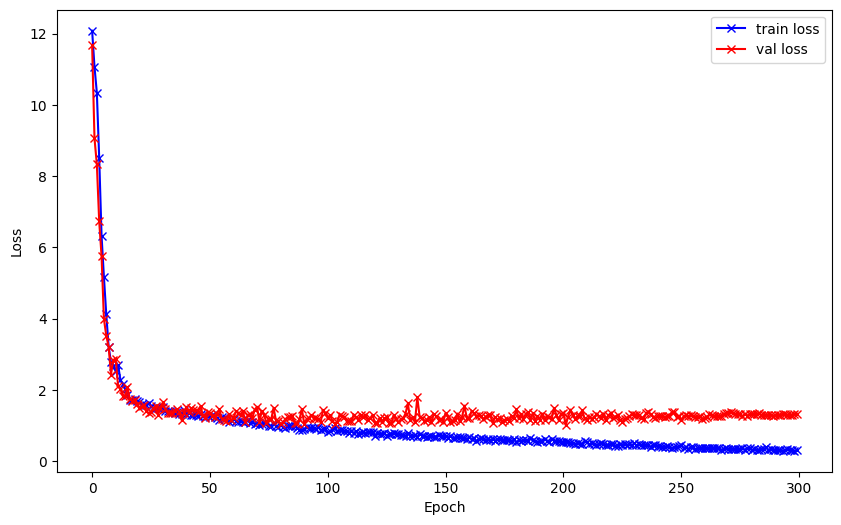

In [ ]:
plot_loss(global_history[-1])

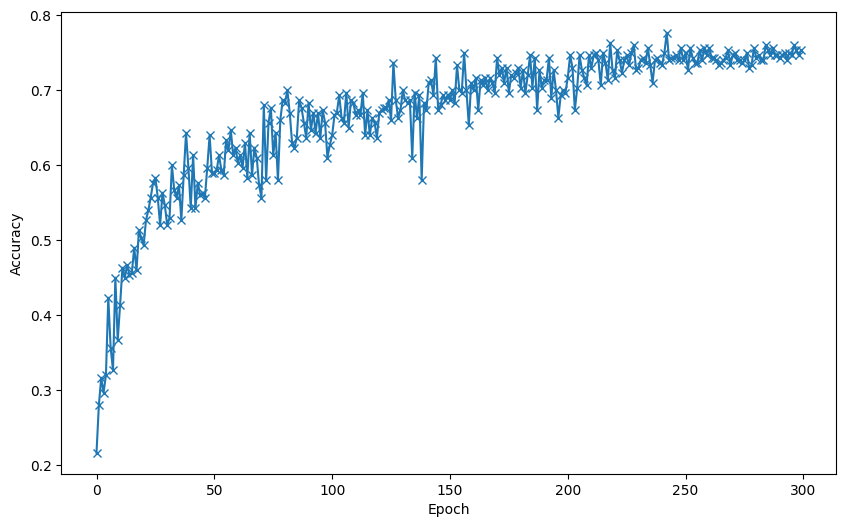

In [ ]:
plot_acc(global_history[-1])

In [ ]:
# device = 'cuda'
# import torch, gc
# import os
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
# train_loader, validation_loader = load_data(mean,std,path,16)

# data,label = next(iter(train_loader))

# import torch
# from torchvision import transforms
# from PIL import Image
# print(label)



In [ ]:
# image = transforms.ToPILImage()(data[1])
# image.show()